## Setup

In [1]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [40]:
!pip install autoelbow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD


## Load Dataset


In [1]:
!gdown --id 146P1MLIAX8sGzgCkZU2D1DSSDEdTaqmY

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=146P1MLIAX8sGzgCkZU2D1DSSDEdTaqmY
To: /content/spotify.zip
100% 16.2M/16.2M [00:00<00:00, 80.5MB/s]


In [3]:
!unzip -o "spotify.zip"  -d  "/content"

Archive:  spotify.zip
  inflating: /content/SpotifyFeatures.csv  


In [13]:
item_df = pd.read_csv("SpotifyFeatures.csv")


## All item features 

In [14]:
item_df.head(1)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.91,0.0,C#,0.346,-1.828,Major,0.0525,166.969,4/4,0.814


In [15]:

numerical_names = ['popularity','acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms']

catagorical=['genre','artist_name']
itemid='track_name'

In [34]:
allcols=[itemid]
for i in catagorical:
  allcols.append(i)
for i in numerical_names:
  allcols.append(i)

In [17]:
df=item_df[allcols]

In [18]:
for i in catagorical:
  ids = list(set(list(df[i].unique())))
  dict_items = {}
  index = 0
  for ids in sorted(ids):
    dict_items[ids] = index
    index += 1
  df[i] = df[i].map(dict_items)


<ipython-input-18-c8806102d7c4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].map(dict_items)


### Analysing all columns with continuous values

#### Corelation with different columns 

In [22]:
def visualise(col):
  X, y = df[numerical_names], df[ col]

  # Create a list of the feature names
  features = np.array(numerical_names)

  # Instantiate the visualizer
  visualizer = FeatureCorrelation(labels=features)

  plt.rcParams['figure.figsize']=(5,5)
  visualizer.fit(X, y)     # Fit the data to the visualizer
  visualizer.title="Features Correlation with "+str(col)
  visualizer.show()
  

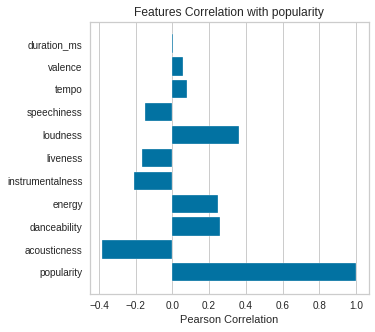

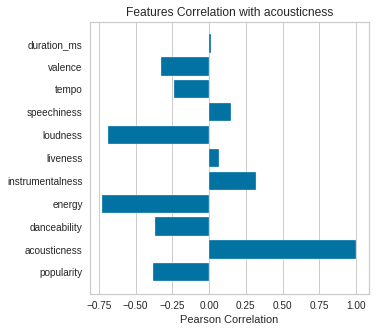

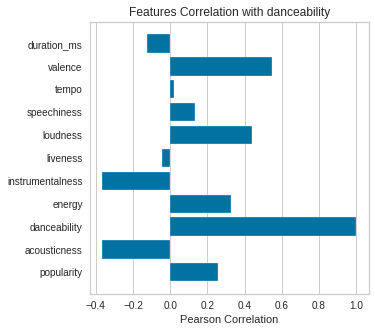

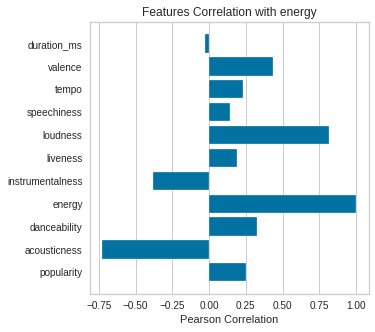

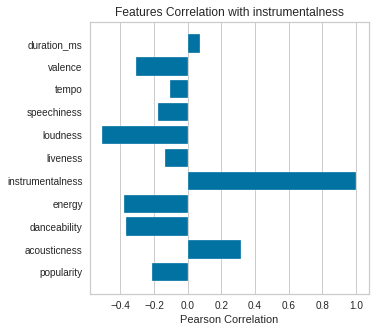

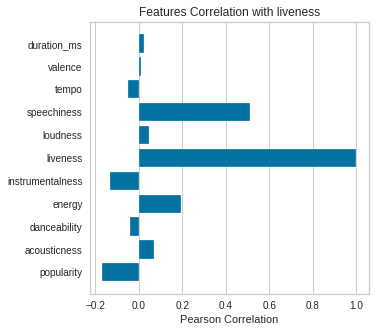

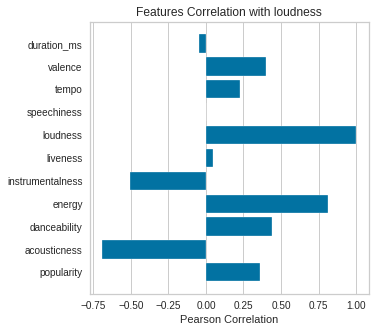

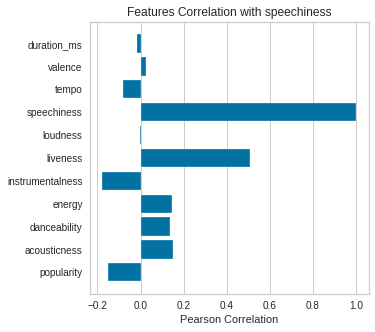

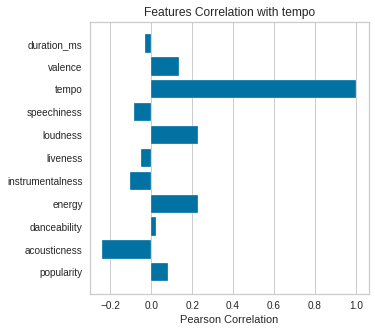

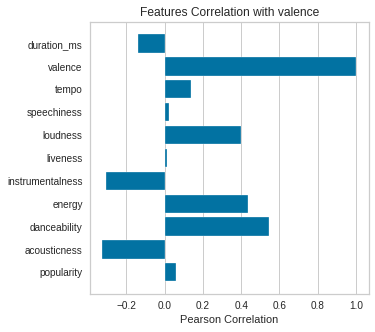

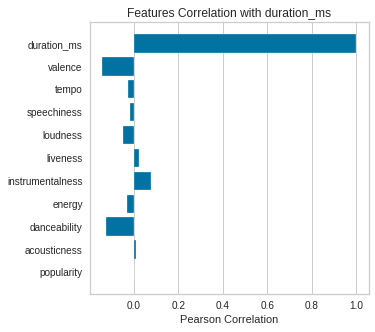

In [23]:
from yellowbrick.target import FeatureCorrelation
for i in numerical_names:
  visualise(i)




## Find similar items based on numerical features

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [25]:
df[numerical_names]=scaler.fit_transform(df[numerical_names])


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


### Find similar songs using continuous features.

#### Apply K-means
- We will use Elbow method to find value of hyperparameter K.

In [35]:
cols=allcols.copy()
cols.remove(itemid)

In [37]:
df_tmp=df[cols]


### Use MeanShift to get best K value

In [38]:
from autoelbow_rupakbob import autoelbow
n =autoelbow.auto_elbow_search(df_tmp)

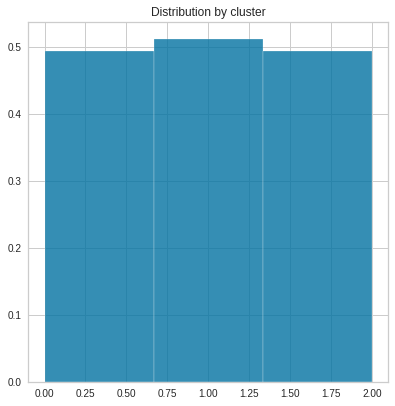

In [40]:

from sklearn.cluster import KMeans
n_clusters_ = n
kmeans = KMeans(n_clusters = n_clusters_, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(df_tmp)

df_tmp.loc[:, 'cluster'] = y_kmeans

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.hist(
    y_kmeans,
    bins=n_clusters_,
    density=True,
    alpha=0.8
)

plt.title('Distribution by cluster')
plt.show()

In [41]:
df_tmp.head(1)

,genre,artist_name,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,cluster
0,15,5181,-2.261007,0.683376,-0.890935,1.286908,-0.489819,0.660661,1.290703,-0.36797,1.595607,1.380744,-1.141368,0


In [42]:
df['cluster']=df_tmp['cluster']

<ipython-input-42-ba58f7161387>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster']=df_tmp['cluster']


#### Find similarity

In [58]:
songs_df=df[df['track_name']=='Perfect']
songs_df=songs_df.head(1)
custer=list(songs_df['cluster'])[0]
artist_name=list(songs_df['artist_name'])[0]
songs_df


,track_name,genre,artist_name,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,cluster
8147,Perfect,8,3037,-0.281887,-0.981377,-0.43298,1.047778,-0.489819,-0.611328,0.773714,-0.404624,1.569587,0.911631,-0.278717,1


In [59]:
cluster_df=df[(df['cluster']==custer) ].sort_values('popularity', ascending=[False])

In [60]:
cluster_df.head(10)

,track_name,genre,artist_name,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,cluster
9027,7 rings,9,828,3.236547,0.590358,0.919334,-0.948768,-0.489819,-0.638563,-0.195745,1.090110,-1.538070,-0.522627,-0.474898,1
107804,7 rings,17,828,3.236547,0.590358,0.919334,-0.948768,-0.489819,-0.638563,-0.195745,1.090110,-1.538070,-0.522627,-0.474898,1
107802,"break up with your girlfriend, i'm bored",17,828,3.181572,-0.920210,0.924721,-0.064366,-0.489819,-0.549796,0.713529,-0.156670,1.693669,-0.461104,-0.375685,1
9026,"break up with your girlfriend, i'm bored",9,828,3.181572,-0.920210,0.924721,-0.064366,-0.489819,-0.549796,0.713529,-0.156670,1.693669,-0.461104,-0.375685,1
66643,Con Calma,12,2934,3.126596,-0.728817,0.983986,1.097122,-0.489812,-0.794914,1.153329,-0.331316,-0.766294,0.773204,-0.352252,1
138918,Con Calma,21,2934,3.126596,-0.728817,0.983986,1.097122,-0.489812,-0.794914,1.153329,-0.331316,-0.766294,0.773204,-0.352252,1
107909,Con Calma,17,2934,3.126596,-0.728817,0.983986,1.097122,-0.489812,-0.794914,1.153329,-0.331316,-0.766294,0.773204,-0.352252,1
9037,Sweet but Psycho,9,978,3.071621,-0.844104,0.887007,0.504991,-0.489819,-0.247182,0.807891,-0.394382,0.496310,0.665538,-0.400942,1
107829,Sweet but Psycho,17,978,3.071621,-0.844104,0.887007,0.504991,-0.489819,-0.247182,0.807891,-0.394382,0.496310,0.665538,-0.400942,1
9048,"Taki Taki (with Selena Gomez, Ozuna & Cardi B)",9,2902,3.016645,-0.607611,1.544307,0.861788,-0.489808,-0.772722,0.894251,0.583421,-0.702893,0.523266,-0.190207,1


In [61]:
cluster_df[cluster_df['artist_name']==artist_name]

,track_name,genre,artist_name,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,duration_ms,cluster
166135,Wagon Wheel,22,3037,1.807183,0.246470,-0.136656,0.349366,-0.489819,-0.368228,0.405436,-0.486018,0.985002,0.527111,0.532033,1
108724,Wagon Wheel,17,3037,1.807183,0.246470,-0.136656,0.349366,-0.489819,-0.368228,0.405436,-0.486018,0.985002,0.527111,0.532033,1
212312,Wagon Wheel,8,3037,1.752208,0.246470,-0.136656,0.349366,-0.489819,-0.368228,0.405436,-0.486018,0.985002,0.527111,0.532033,1
110893,If I Told You,17,3037,1.422354,-0.069230,-0.120493,0.262065,-0.489819,0.736315,0.481126,-0.481706,-1.088636,-0.564924,-0.191720,1
111102,For The First Time,17,3037,1.422354,-1.018077,-0.039678,0.884562,-0.489819,-0.929073,0.717197,-0.456371,0.788037,0.811656,-0.320083,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8014,"You, Me And My Guitar",8,3037,-0.281887,-0.839312,-0.346777,1.275521,-0.489819,0.448831,0.782383,-0.332394,1.695902,1.465338,-0.319184,1
8147,Perfect,8,3037,-0.281887,-0.981377,-0.432980,1.047778,-0.489819,-0.611328,0.773714,-0.404624,1.569587,0.911631,-0.278717,1
8564,Shine,8,3037,-0.336863,-0.824373,0.041138,0.656819,-0.489819,-0.647137,0.518971,-0.454215,1.434630,1.088510,0.142805,1
8390,Leavin' The Light On,8,3037,-0.336863,0.108351,0.725376,-0.455325,-0.489714,0.695966,-0.007355,-0.500572,-1.316444,0.715526,0.018478,1
